In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize


In [ ]:
beta = 40.0
nw = 100
omega_n = np.pi / beta * (2 * np.arange(nw) + 1)
D = 1.0
Gamma = 0.2
Delta_exact = -1j * Gamma * np.ones_like(omega_n)

In [ ]:
def fit_bath(nbath):
    def hybridization_fit(params):
        eps = params[:nbath]
        V = params[nbath:]
        Delta_fit = np.zeros_like(omega_n, dtype=complex)
        for i in range(nbath):
            Delta_fit += (V[i] ** 2) / (1j * omega_n - eps[i])
        return Delta_fit

    def loss(params):
        Delta_fit = hybridization_fit(params)
        return np.sum(np.abs(Delta_fit - Delta_exact) ** 2)

    eps_init = np.linspace(-D, D, nbath)
    V_init = np.sqrt(Gamma / nbath) * np.ones(nbath)
    params_init = np.concatenate([eps_init, V_init])

    result = minimize(loss, params_init, method='L-BFGS-B')
    params_opt = result.x
    Delta_fitted = hybridization_fit(params_opt)
    return Delta_fitted, params_opt


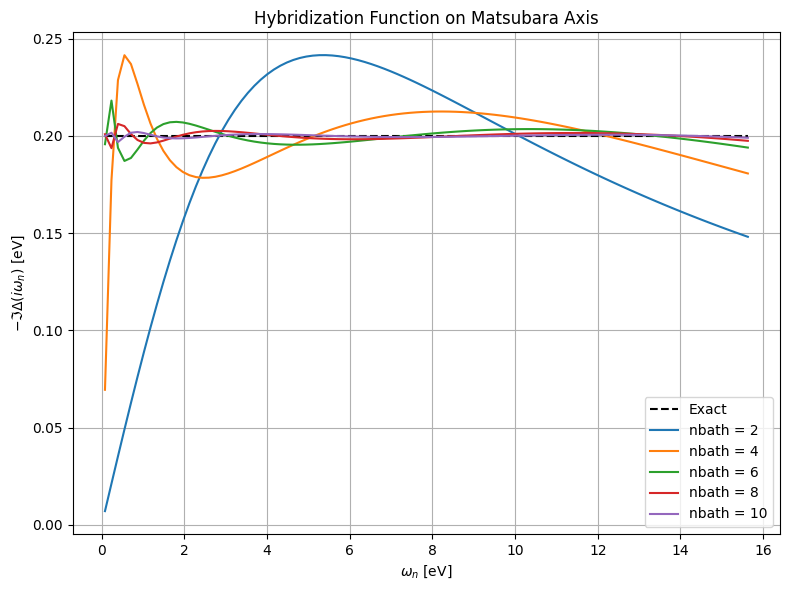

In [8]:
# Fit for bath sizes 2, 4, 6
bath_sizes = [2, 4, 6, 8, 10]
fitted_deltas = {}
for nb in bath_sizes:
    Delta_fit, _ = fit_bath(nb)
    fitted_deltas[nb] = Delta_fit

# Plot
plt.figure(figsize=(8, 6))
plt.plot(omega_n, -Delta_exact.imag, 'k--', label='Exact')

for nb in bath_sizes:
    plt.plot(omega_n, -fitted_deltas[nb].imag, label=f'nbath = {nb}')

plt.xlabel(r'$\omega_n$ [eV]')
plt.ylabel(r'$-\Im \Delta(i\omega_n)$ [eV]')
plt.title('Hybridization Function on Matsubara Axis')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


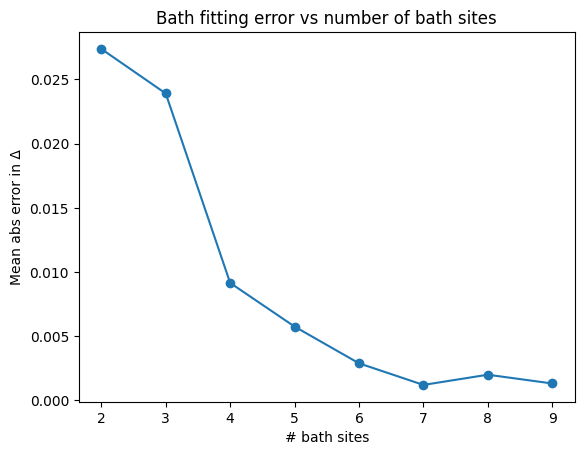

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from edpyt.fit_cg import get_initial_bath, fit_hybrid, Delta

beta = 1000
nmats = 5000
wn = 1j * (2 * np.arange(nmats) + 1) * np.pi / beta
true_delta = 2 * (wn - np.sqrt(wn**2 - 1))

errors = []
nbaths = np.arange(2, 10)

for nbath in nbaths:
    p = get_initial_bath(nbath=nbath)
    fit_hybrid(p, nmats, true_delta, beta)
    fitted = Delta(wn)(p)
    err = np.mean(np.abs(fitted - true_delta))
    errors.append(err)

plt.plot(nbaths, errors, 'o-')
plt.xlabel("# bath sites")
plt.ylabel("Mean abs error in Δ")
plt.title("Bath fitting error vs number of bath sites")
plt.show()


nbath = 2 | χ² mean = 9.00e-03, std = 6.41e-11
nbath = 3 | χ² mean = 1.26e-03, std = 1.75e-10
nbath = 4 | χ² mean = 1.15e-04, std = 1.41e-09
nbath = 5 | χ² mean = 7.98e-06, std = 6.88e-09
nbath = 6 | χ² mean = 2.61e-06, std = 1.21e-06
nbath = 7 | χ² mean = 4.83e-06, std = 1.36e-06
nbath = 8 | χ² mean = 2.18e-06, std = 1.09e-06


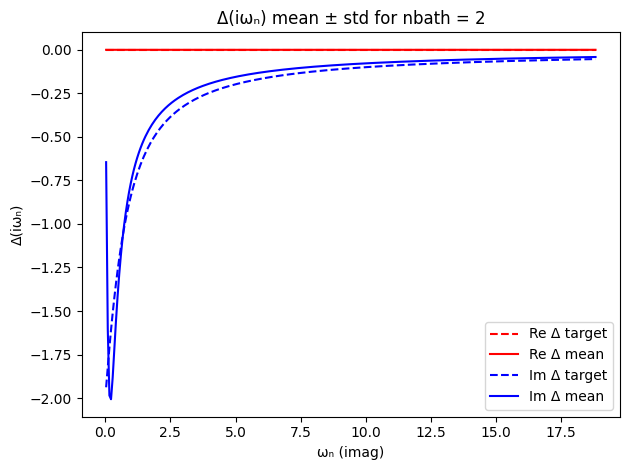

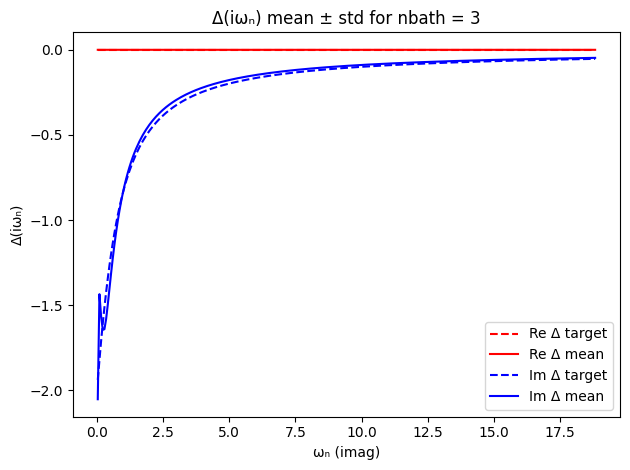

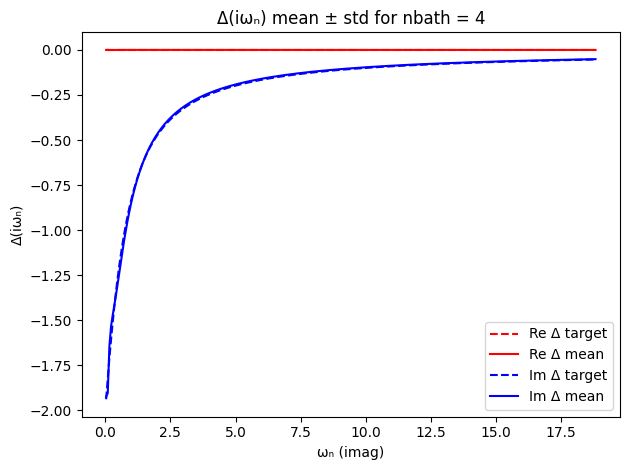

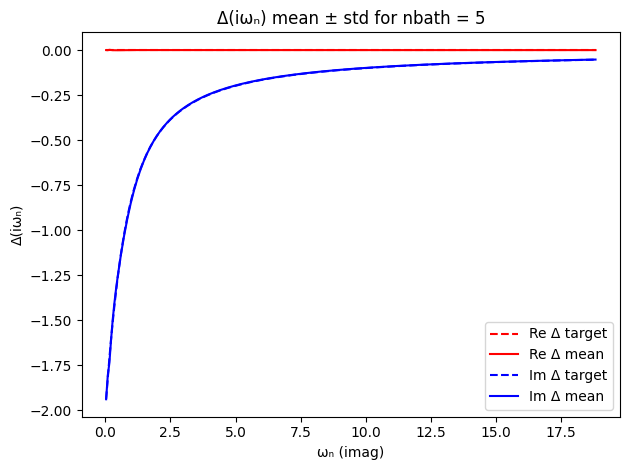

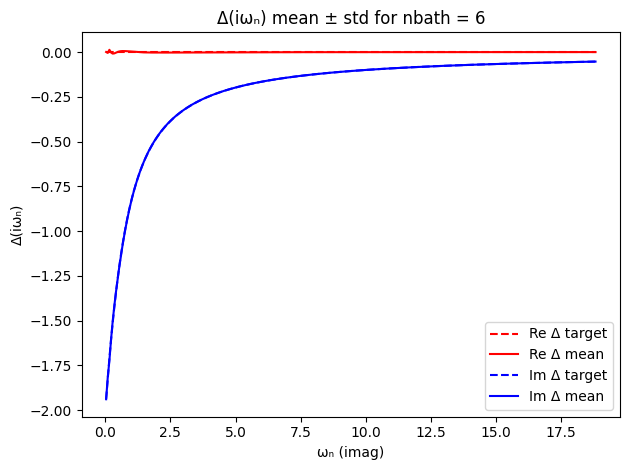

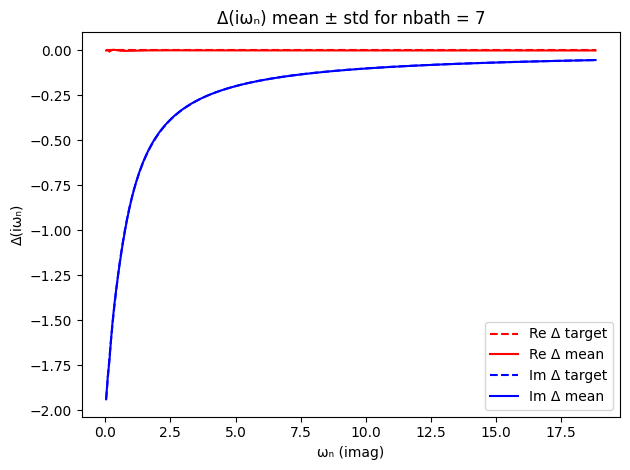

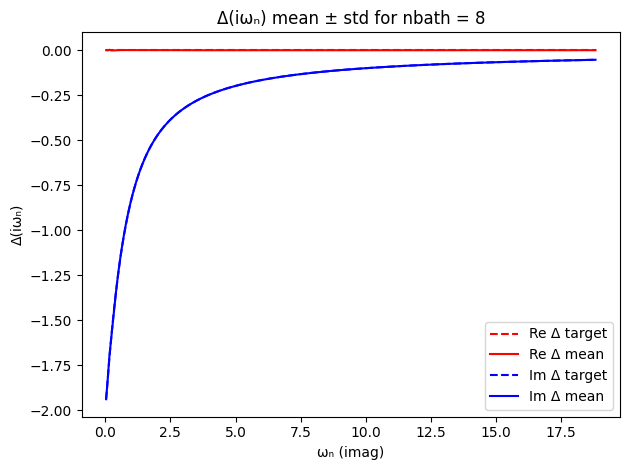

In [2]:
def test_fit_stability(nbath, ntrials=10, beta=100, nmats=300):
    wn = 1j * (2 * np.arange(nmats) + 1) * np.pi / beta
    delta_target = 2 * (wn - np.sqrt(wn**2 - 1))  # e.g., Bethe lattice hybridization
    delta_fn = Delta(wn)

    deltas = []
    chi2s = []

    for trial in range(ntrials):
        # Slightly randomized initial guess
        p0 = get_initial_bath(nbath=nbath).copy()
        p0 += 0.1 * np.random.randn(p0.size)  # small random noise

        fit_hybrid(p0, nmats, delta_target, beta)
        delta_fit = delta_fn(p0)
        deltas.append(delta_fit)
        chi2 = np.mean(np.abs(delta_fit - delta_target)**2)
        chi2s.append(chi2)

    deltas = np.array(deltas)
    chi2s = np.array(chi2s)

    delta_mean = np.mean(deltas, axis=0)
    delta_std = np.std(deltas, axis=0)
    return wn.imag, delta_mean, delta_std, chi2s


if __name__ == "__main__":
    beta = 100
    nbaths = [2, 3, 4, 5, 6, 7, 8]
    ntrials = 10
    nmats = 300

    # Recompute target just for plotting clarity
    delta_target = 2 * (1j * (2 * np.arange(nmats) + 1) * np.pi / beta -
                        np.sqrt((1j * (2 * np.arange(nmats) + 1) * np.pi / beta)**2 - 1))

    for nbath in nbaths:
        wn_imag, delta_mean, delta_std, chi2s = test_fit_stability(nbath, ntrials, beta, nmats)

        plt.figure()
        plt.title(f"Δ(iωₙ) mean ± std for nbath = {nbath}")


        plt.plot(wn_imag, delta_target.real, 'r--', label='Re Δ target')
        plt.plot(wn_imag, delta_mean.real, 'r-', label='Re Δ mean')

        plt.plot(wn_imag, delta_target.imag, 'b--', label='Im Δ target')
        plt.plot(wn_imag, delta_mean.imag, 'b-', label='Im Δ mean')

        plt.xlabel("ωₙ (imag)")
        plt.ylabel("Δ(iωₙ)")
        plt.legend()
        plt.tight_layout()

        print(f"nbath = {nbath} | χ² mean = {chi2s.mean():.2e}, std = {chi2s.std():.2e}")

    plt.show()


bandwidth=2.0 → chi² = 1.201e-06


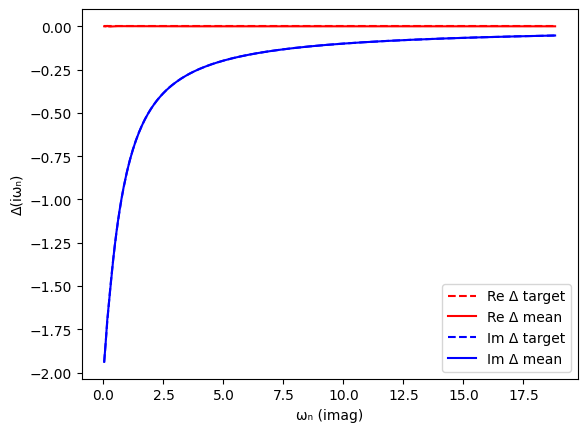

bandwidth=3.0 → chi² = 6.480e-05


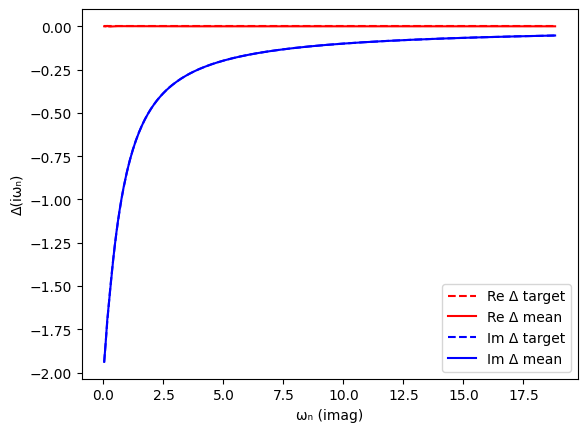

bandwidth=4.0 → chi² = 7.500e-05


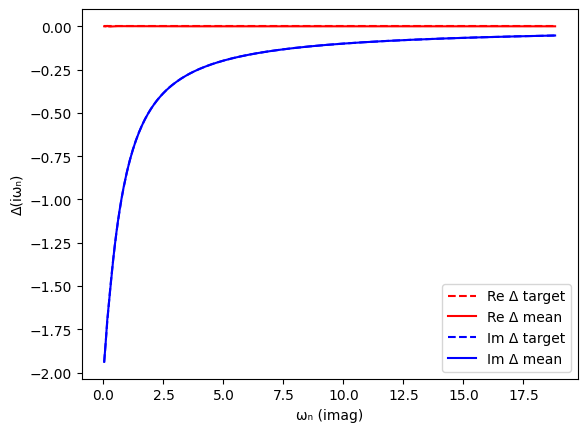

bandwidth=5.0 → chi² = 8.164e-05


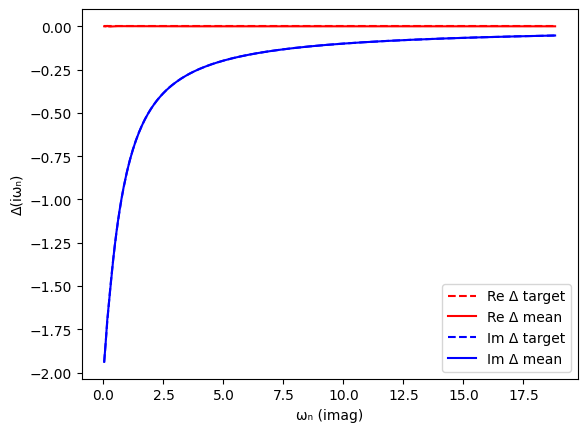

bandwidth=6.0 → chi² = 8.623e-05


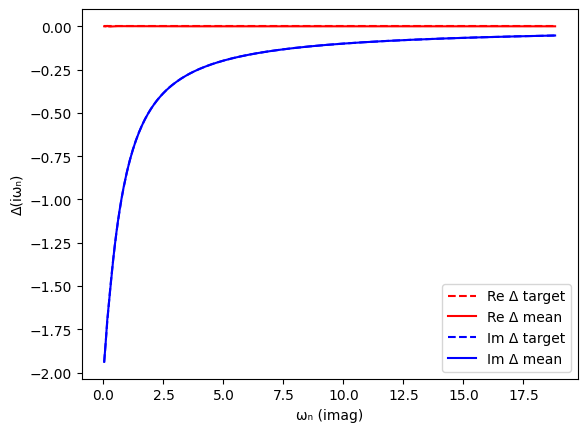

In [8]:
bandwidths = [2.0, 3.0, 4.0, 5.0, 6.0]
wn = 1j * (2 * np.arange(nmats) + 1) * np.pi / beta
for bw in bandwidths:
    p = get_initial_bath(nbath=6, bandwidth=bw)
    fit_hybrid(p, nmats, delta_target, beta)
    delta_fit = Delta(wn)(p)
    chi2 = np.mean(np.abs(delta_fit - delta_target)**2)
    print(f"bandwidth={bw:.1f} → chi² = {chi2:.3e}")


    plt.plot(wn.imag, delta_target.real, 'r--', label='Re Δ target')
    plt.plot(wn.imag, delta_mean.real, 'r-', label='Re Δ mean')

    plt.plot(wn.imag, delta_target.imag, 'b--', label='Im Δ target')
    plt.plot(wn.imag, delta_mean.imag, 'b-', label='Im Δ mean')

    plt.xlabel("ωₙ (imag)")
    plt.ylabel("Δ(iωₙ)")
    plt.legend()
    plt.show()


/home/anooja/Work/software/edpyt/edpyt/lanczos.py:44: RuntimeWarning: divide by zero encountered in double_scalars
  scal(1/b,v)


[nbath=3, bw=2.0] Iter 0: Δ diff = 2.265e+00
[nbath=3, bw=2.0] Iter 1: Δ diff = 1.131e+00
[nbath=3, bw=2.0] Iter 2: Δ diff = 6.866e-01
[nbath=3, bw=2.0] Iter 3: Δ diff = 4.737e-01
[nbath=3, bw=2.0] Iter 4: Δ diff = 3.521e-01
[nbath=3, bw=2.0] Iter 5: Δ diff = 2.751e-01
[nbath=3, bw=2.0] Iter 6: Δ diff = 2.232e-01
[nbath=3, bw=2.0] Iter 7: Δ diff = 1.867e-01
[nbath=3, bw=2.0] Iter 8: Δ diff = 1.594e-01
[nbath=3, bw=2.0] Iter 9: Δ diff = 1.400e-01
[nbath=3, bw=2.0] Iter 10: Δ diff = 1.231e-01
[nbath=3, bw=2.0] Iter 11: Δ diff = 1.099e-01
[nbath=3, bw=2.0] Iter 12: Δ diff = 1.010e-01
[nbath=3, bw=2.0] Iter 13: Δ diff = 9.203e-02
[nbath=3, bw=2.0] Iter 14: Δ diff = 8.560e-02
[nbath=3, bw=2.0] Iter 15: Δ diff = 7.901e-02
[nbath=3, bw=2.0] Iter 16: Δ diff = 7.401e-02
[nbath=3, bw=2.0] Iter 17: Δ diff = 6.820e-02
[nbath=3, bw=2.0] Iter 18: Δ diff = 6.220e-02
[nbath=3, bw=2.0] Iter 19: Δ diff = 5.823e-02
[nbath=4, bw=2.0] Iter 0: Δ diff = 1.895e+00


/home/anooja/Work/software/edpyt/edpyt/lanczos.py:44: RuntimeWarning: divide by zero encountered in double_scalars
  scal(1/b,v)


[nbath=4, bw=2.0] Iter 1: Δ diff = 1.050e+00
[nbath=4, bw=2.0] Iter 2: Δ diff = 6.876e-01
[nbath=4, bw=2.0] Iter 3: Δ diff = 4.890e-01
[nbath=4, bw=2.0] Iter 4: Δ diff = 3.670e-01
[nbath=4, bw=2.0] Iter 5: Δ diff = 2.879e-01
[nbath=4, bw=2.0] Iter 6: Δ diff = 2.334e-01
[nbath=4, bw=2.0] Iter 7: Δ diff = 1.932e-01
[nbath=4, bw=2.0] Iter 8: Δ diff = 1.628e-01
[nbath=4, bw=2.0] Iter 9: Δ diff = 1.398e-01
[nbath=4, bw=2.0] Iter 10: Δ diff = 1.195e-01
[nbath=4, bw=2.0] Iter 11: Δ diff = 1.052e-01
[nbath=4, bw=2.0] Iter 12: Δ diff = 9.136e-02
[nbath=4, bw=2.0] Iter 13: Δ diff = 8.370e-02
[nbath=4, bw=2.0] Iter 14: Δ diff = 7.560e-02
[nbath=4, bw=2.0] Iter 15: Δ diff = 6.863e-02
[nbath=4, bw=2.0] Iter 16: Δ diff = 6.316e-02
[nbath=4, bw=2.0] Iter 17: Δ diff = 5.848e-02
[nbath=4, bw=2.0] Iter 18: Δ diff = 5.452e-02
[nbath=4, bw=2.0] Iter 19: Δ diff = 5.113e-02
[nbath=5, bw=2.0] Iter 0: Δ diff = 2.607e+00
[nbath=5, bw=2.0] Iter 1: Δ diff = 1.267e+00
[nbath=5, bw=2.0] Iter 2: Δ diff = 7.449e-01


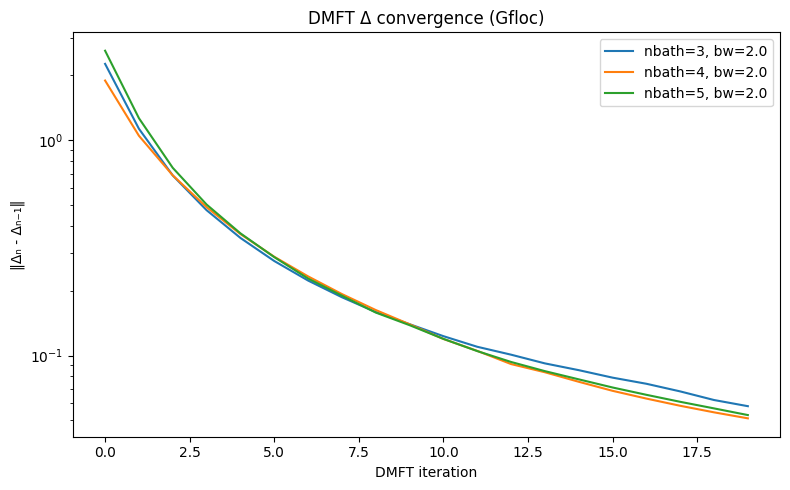

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from edpyt.fit_cg import get_initial_bath, fit_hybrid, Delta
from edpyt.dmft import Gfimp
from edpyt.nano_dmft import Gfimp as GfimpMulti
from edpyt.nano_dmft import Gfloc

def test_dmft_convergence_gfloc(H, S, idx_neq, idx_inv,
                                 nbath, bandwidth, beta=100, nmats=300, max_iter=10,
                                 ):
    wn = 1j * (2 * np.arange(nmats) + 1) * np.pi / beta
    z = wn
    delta_fn = Delta(z)


    gfimp_list = []
    for i in range(len(idx_neq)):
        nsites = nbath + 1
        gf = Gfimp(nsites, nmats=nmats, beta=beta, U=3.0)
        gf.Delta.x[:] = get_initial_bath(nbath=nbath, bandwidth=bandwidth)
        gfimp_list.append(gf)

    gfimp = GfimpMulti(gfimp_list)


    def Hybrid(z):
        z = np.atleast_1d(z)
        deltas = np.stack([gf.Delta(z) for gf in gfimp])
        return np.mean(deltas, axis=0)

    gfloc = Gfloc(H, S, Hybrid, idx_neq, idx_inv, nmats=nmats, beta=beta)
    gfloc.update(mu=1.0)
    gfloc.set_local(lambda z: 0 * z)

    delta_old = np.stack([gf.free(z) for gf in gfimp])
    errors = []

    for it in range(max_iter):

        for i, gf in enumerate(gfimp):
            fit_hybrid(gf.Delta.x, nmats, delta_old[i], beta)


        gfimp.update(gfloc.mu - gfloc.ed)
        gfimp.solve()

        sigma = gfimp.Sigma(z)
        gfloc.set_local(lambda z: sigma)

        delta_new = np.stack([gfloc.Delta(z)[i] for i in range(len(gfimp))])
        eps = np.linalg.norm(delta_new - delta_old)
        print(f"[nbath={nbath}, bw={bandwidth}] Iter {it}: Δ diff = {eps:.3e}")
        errors.append(eps)
        delta_old = delta_new.copy()

    return errors


if __name__ == "__main__":
    beta = 100
    nmats = 300
    max_iter = 20


    H = np.eye(3) * -1.0
    S = np.eye(3)
    idx_neq = np.array([0, 1, 2])
    idx_inv = np.array([0, 1, 2])

    configs = [
        (3, 2.0),
        # (3, 4.0),
        (4, 2.0),
        # (4, 4.0),
        (5, 2.0),
        # (5, 4.0),
    ]

    plt.figure(figsize=(8, 5))
    for nbath, bw in configs:
        err = test_dmft_convergence_gfloc(H, S, idx_neq, idx_inv,
                                          nbath, bw, beta=beta, nmats=nmats,
                                          max_iter=max_iter)
        plt.plot(err, label=f"nbath={nbath}, bw={bw}")

    plt.xlabel("DMFT iteration")
    plt.ylabel("‖Δₙ - Δₙ₋₁‖")
    plt.yscale('log')
    plt.title("DMFT Δ convergence (Gfloc)")
    plt.legend()
    plt.tight_layout()
    plt.show()


/home/anooja/Work/software/edpyt/edpyt/lanczos.py:44: RuntimeWarning: divide by zero encountered in double_scalars
  scal(1/b,v)


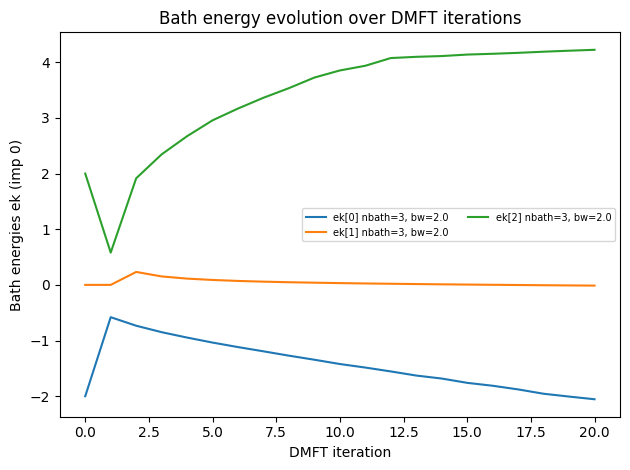

/home/anooja/Work/software/edpyt/edpyt/lanczos.py:44: RuntimeWarning: divide by zero encountered in double_scalars
  scal(1/b,v)


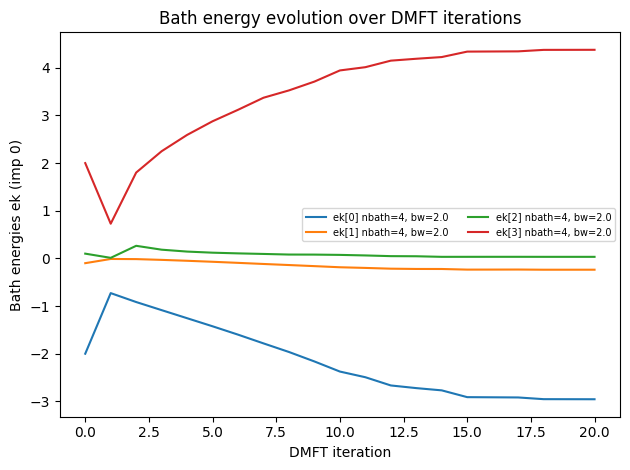

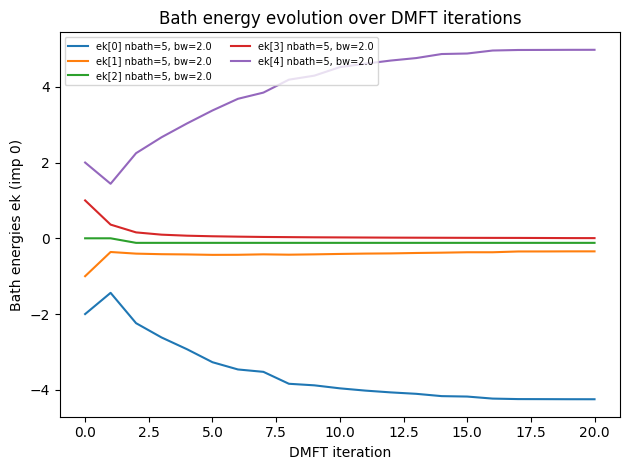

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from edpyt.fit_cg import get_initial_bath, fit_hybrid, Delta
from edpyt.dmft import Gfimp
from edpyt.nano_dmft import Gfimp as GfimpMulti
from edpyt.nano_dmft import Gfloc


def test_dmft_convergence_gfloc(H, S, idx_neq, idx_inv,
                                 nbath, bandwidth, beta=100, nmats=300, max_iter=10):
    wn = 1j * (2 * np.arange(nmats) + 1) * np.pi / beta
    z = wn
    delta_fn = Delta(z)

    gfimp_list = []
    for i in range(len(idx_neq)):
        nsites = nbath + 1
        gf = Gfimp(nsites, nmats=nmats, beta=beta, U=3.0)
        gf.Delta.x[:] = get_initial_bath(nbath=nbath, bandwidth=bandwidth)
        gfimp_list.append(gf)

    gfimp = GfimpMulti(gfimp_list)

    def Hybrid(z):
        z = np.atleast_1d(z)
        deltas = np.stack([gf.Delta(z) for gf in gfimp])
        return np.mean(deltas, axis=0)

    gfloc = Gfloc(H, S, Hybrid, idx_neq, idx_inv, nmats=nmats, beta=beta)
    gfloc.update(mu=1.0)
    gfloc.set_local(lambda z: 0 * z)

    delta_old = np.stack([gf.free(z) for gf in gfimp])
    errors = []

    # Initialize bath history and store initial guess
    bath_history = {i: {'ek': [], 'vk': []} for i in range(len(gfimp))}
    for i, gf in enumerate(gfimp):
        p_init = gf.Delta.x.copy()
        bath_history[i]['ek'].append(p_init[:nbath].copy())
        bath_history[i]['vk'].append(p_init[nbath:].copy())

    for it in range(max_iter):
        for i, gf in enumerate(gfimp):
            fit_hybrid(gf.Delta.x, nmats, delta_old[i], beta)
            p = gf.Delta.x.copy()
            bath_history[i]['ek'].append(p[:nbath].copy())
            bath_history[i]['vk'].append(p[nbath:].copy())

        gfimp.update(gfloc.mu - gfloc.ed)
        gfimp.solve()

        sigma = gfimp.Sigma(z)
        gfloc.set_local(lambda z: sigma)

        delta_new = np.stack([gfloc.Delta(z)[i] for i in range(len(gfimp))])
        eps = np.linalg.norm(delta_new - delta_old)
        errors.append(eps)
        delta_old = delta_new.copy()

    return errors, bath_history


if __name__ == "__main__":
    beta = 100
    nmats = 300
    max_iter = 20

    H = np.eye(3) * -1.0
    S = np.eye(3)
    idx_neq = np.array([0, 1, 2])
    idx_inv = np.array([0, 1, 2])

    configs = [
        (3, 2.0),
        (4, 2.0),
        (5, 2.0),
    ]

    for nbath, bw in configs:
        _, bath_history = test_dmft_convergence_gfloc(
            H, S, idx_neq, idx_inv,
            nbath, bw, beta=beta, nmats=nmats,
            max_iter=max_iter
        )
        ek_array = np.array(bath_history[0]['ek'])  # shape: (max_iter + 1, nbath)
        for i in range(ek_array.shape[1]):
            plt.plot(range(max_iter + 1), ek_array[:, i], label=f"ek[{i}] nbath={nbath}, bw={bw}")
        plt.xlabel("DMFT iteration")
        plt.ylabel("Bath energies ek (imp 0)")
        plt.title("Bath energy evolution over DMFT iterations")
        plt.legend(fontsize=7, ncol=2)
        plt.tight_layout()
        plt.show()


/home/anooja/Work/software/edpyt/edpyt/lanczos.py:44: RuntimeWarning: divide by zero encountered in double_scalars
  scal(1/b,v)


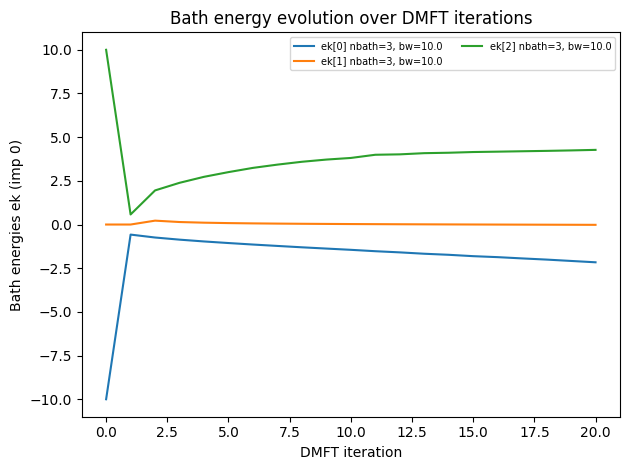

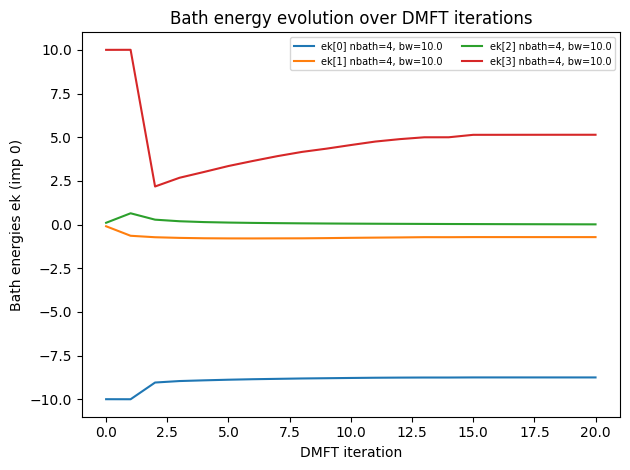

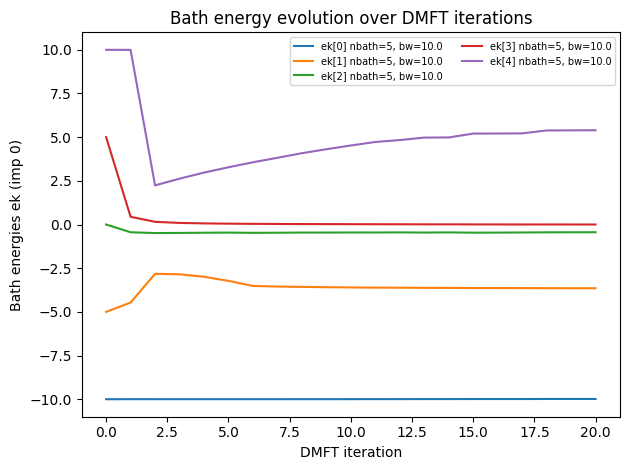

In [2]:
def test_dmft_convergence_gfloc(H, S, idx_neq, idx_inv,
                                 nbath, bandwidth, beta=100, nmats=300, max_iter=10):
    wn = 1j * (2 * np.arange(nmats) + 1) * np.pi / beta
    z = wn
    delta_fn = Delta(z)

    gfimp_list = []
    for i in range(len(idx_neq)):
        nsites = nbath + 1
        gf = Gfimp(nsites, nmats=nmats, beta=beta, U=3.0)
        gf.Delta.x[:] = get_initial_bath(nbath=nbath, bandwidth=bandwidth)
        gfimp_list.append(gf)

    gfimp = GfimpMulti(gfimp_list)

    def Hybrid(z):
        z = np.atleast_1d(z)
        deltas = np.stack([gf.Delta(z) for gf in gfimp])
        return np.mean(deltas, axis=0)

    gfloc = Gfloc(H, S, Hybrid, idx_neq, idx_inv, nmats=nmats, beta=beta)
    gfloc.update(mu=1.0)
    gfloc.set_local(lambda z: 0 * z)

    delta_old = np.stack([gf.free(z) for gf in gfimp])
    errors = []

    # Initialize bath history and store initial guess
    bath_history = {i: {'ek': [], 'vk': []} for i in range(len(gfimp))}
    for i, gf in enumerate(gfimp):
        p_init = gf.Delta.x.copy()
        bath_history[i]['ek'].append(p_init[:nbath].copy())
        bath_history[i]['vk'].append(p_init[nbath:].copy())

    for it in range(max_iter):
        for i, gf in enumerate(gfimp):
            fit_hybrid(gf.Delta.x, nmats, delta_old[i], beta)
            p = gf.Delta.x.copy()
            bath_history[i]['ek'].append(p[:nbath].copy())
            bath_history[i]['vk'].append(p[nbath:].copy())

        gfimp.update(gfloc.mu - gfloc.ed)
        gfimp.solve()

        sigma = gfimp.Sigma(z)
        gfloc.set_local(lambda z: sigma)

        delta_new = np.stack([gfloc.Delta(z)[i] for i in range(len(gfimp))])
        eps = np.linalg.norm(delta_new - delta_old)
        errors.append(eps)
        delta_old = delta_new.copy()

    return errors, bath_history


if __name__ == "__main__":
    beta = 100
    nmats = 300
    max_iter = 20

    H = np.eye(3) * -1.0
    S = np.eye(3)
    idx_neq = np.array([0, 1, 2])
    idx_inv = np.array([0, 1, 2])

    configs = [
        (3, 10.0),
        (4, 10.0),
        (5, 10.0),
    ]

    for nbath, bw in configs:
        _, bath_history = test_dmft_convergence_gfloc(
            H, S, idx_neq, idx_inv,
            nbath, bw, beta=beta, nmats=nmats,
            max_iter=max_iter
        )
        ek_array = np.array(bath_history[0]['ek'])  # shape: (max_iter + 1, nbath)
        for i in range(ek_array.shape[1]):
            plt.plot(range(max_iter + 1), ek_array[:, i], label=f"ek[{i}] nbath={nbath}, bw={bw}")
        plt.xlabel("DMFT iteration")
        plt.ylabel("Bath energies ek (imp 0)")
        plt.title("Bath energy evolution over DMFT iterations")
        plt.legend(fontsize=7, ncol=2)
        plt.tight_layout()
        plt.show()


/home/anooja/Work/software/edpyt/edpyt/lanczos.py:44: RuntimeWarning: divide by zero encountered in double_scalars
  scal(1/b,v)


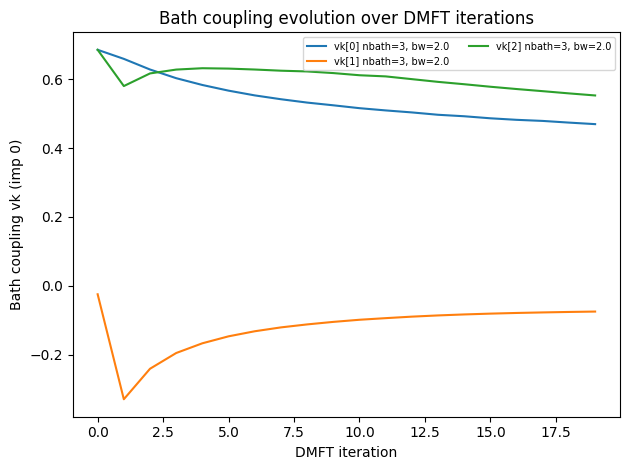

/home/anooja/Work/software/edpyt/edpyt/lanczos.py:44: RuntimeWarning: divide by zero encountered in double_scalars
  scal(1/b,v)


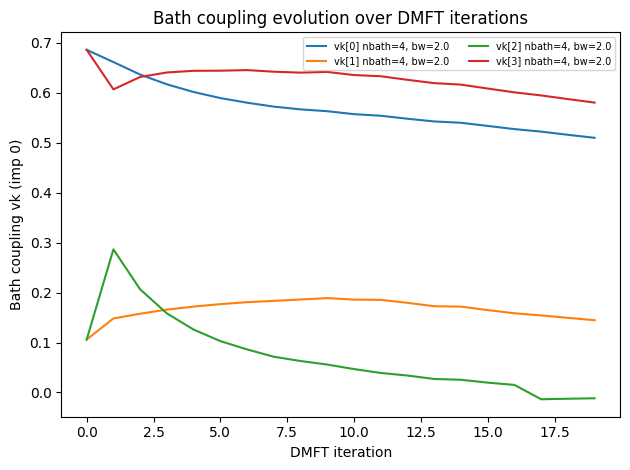

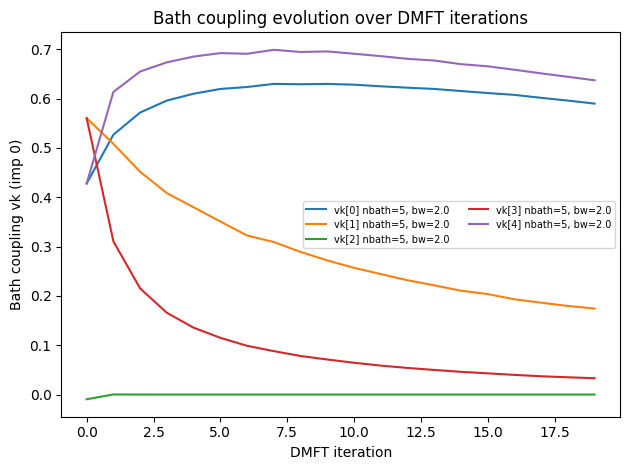

In [ ]:
def test_dmft_convergence_gfloc(H, S, idx_neq, idx_inv,
                                 nbath, bandwidth, beta=100, nmats=300, max_iter=10):
    wn = 1j * (2 * np.arange(nmats) + 1) * np.pi / beta
    z = wn
    delta_fn = Delta(z)

    gfimp_list = []
    for i in range(len(idx_neq)):
        nsites = nbath + 1
        gf = Gfimp(nsites, nmats=nmats, beta=beta, U=3.0)
        gf.Delta.x[:] = get_initial_bath(nbath=nbath, bandwidth=bandwidth)
        gfimp_list.append(gf)

    gfimp = GfimpMulti(gfimp_list)

    def Hybrid(z):
        z = np.atleast_1d(z)
        deltas = np.stack([gf.Delta(z) for gf in gfimp])
        return np.mean(deltas, axis=0)

    gfloc = Gfloc(H, S, Hybrid, idx_neq, idx_inv, nmats=nmats, beta=beta)
    gfloc.update(mu=1.0)
    gfloc.set_local(lambda z: 0 * z)

    delta_old = np.stack([gf.free(z) for gf in gfimp])
    errors = []


    bath_history = {i: {'ek': [], 'vk': []} for i in range(len(gfimp))}

    for it in range(max_iter):
        for i, gf in enumerate(gfimp):
            fit_hybrid(gf.Delta.x, nmats, delta_old[i], beta)
            p = gf.Delta.x.copy()
            bath_history[i]['ek'].append(p[:nbath].copy())
            bath_history[i]['vk'].append(p[nbath:].copy())

        gfimp.update(gfloc.mu - gfloc.ed)
        gfimp.solve()

        sigma = gfimp.Sigma(z)
        gfloc.set_local(lambda z: sigma)

        delta_new = np.stack([gfloc.Delta(z)[i] for i in range(len(gfimp))])
        eps = np.linalg.norm(delta_new - delta_old)
        errors.append(eps)
        delta_old = delta_new.copy()

    return errors, bath_history


if __name__ == "__main__":
    beta = 100
    nmats = 300
    max_iter = 20

    H = np.eye(3) * -1.0
    S = np.eye(3)
    idx_neq = np.array([0, 1, 2])
    idx_inv = np.array([0, 1, 2])

    configs = [
        (3, 2.0),
        (4, 2.0),
        (5, 2.0),
]


    for nbath, bw in configs:
        _, bath_history = test_dmft_convergence_gfloc(
            H, S, idx_neq, idx_inv,
            nbath, bw, beta=beta, nmats=nmats,
            max_iter=max_iter
        )
        vk_array = np.array(bath_history[0]['vk'])
        for i in range(vk_array.shape[1]):
            plt.plot(range(max_iter), vk_array[:, i], label=f"vk[{i}] nbath={nbath}, bw={bw}",)
        plt.xlabel("DMFT iteration")
        plt.ylabel("Bath coupling vk (imp 0)")
        plt.title("Bath coupling evolution over DMFT iterations")
        plt.legend(fontsize=7, ncol=2)
        plt.tight_layout()
        plt.show()


/home/anooja/Work/software/edpyt/edpyt/lanczos.py:44: RuntimeWarning: divide by zero encountered in double_scalars
  scal(1/b,v)
/home/anooja/Work/software/edpyt/edpyt/lanczos.py:44: RuntimeWarning: divide by zero encountered in double_scalars
  scal(1/b,v)


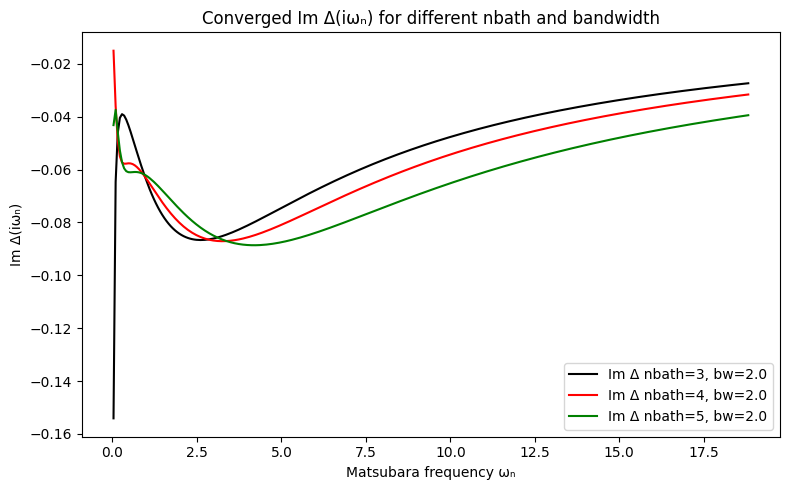

In [28]:
def test_dmft_convergence_gfloc(H, S, idx_neq, idx_inv,
                                 nbath, bandwidth, beta=100, nmats=300, max_iter=10):
    wn = 1j * (2 * np.arange(nmats) + 1) * np.pi / beta
    z = wn
    delta_fn = Delta(z)

    gfimp_list = []
    for i in range(len(idx_neq)):
        nsites = nbath + 1
        gf = Gfimp(nsites, nmats=nmats, beta=beta, U=3.0)
        gf.Delta.x[:] = get_initial_bath(nbath=nbath, bandwidth=bandwidth)
        gfimp_list.append(gf)

    gfimp = GfimpMulti(gfimp_list)

    def Hybrid(z):
        z = np.atleast_1d(z)
        deltas = np.stack([gf.Delta(z) for gf in gfimp])
        return np.mean(deltas, axis=0)

    gfloc = Gfloc(H, S, Hybrid, idx_neq, idx_inv, nmats=nmats, beta=beta)
    gfloc.update(mu=1.0)
    gfloc.set_local(lambda z: 0 * z)

    delta_old = np.stack([gf.free(z) for gf in gfimp])
    errors = []


    bath_history = {i: {'ek': [], 'vk': []} for i in range(len(gfimp))}

    for it in range(max_iter):
        for i, gf in enumerate(gfimp):
            fit_hybrid(gf.Delta.x, nmats, delta_old[i], beta)
            p = gf.Delta.x.copy()
            bath_history[i]['ek'].append(p[:nbath].copy())
            bath_history[i]['vk'].append(p[nbath:].copy())

        gfimp.update(gfloc.mu - gfloc.ed)
        gfimp.solve()

        sigma = gfimp.Sigma(z)
        gfloc.set_local(lambda z: sigma)

        delta_new = np.stack([gfloc.Delta(z)[i] for i in range(len(gfimp))])
        eps = np.linalg.norm(delta_new - delta_old)
        errors.append(eps)
        delta_old = delta_new.copy()

    return errors, bath_history, z


if __name__ == "__main__":
    beta = 100
    nmats = 300
    max_iter = 20

    H = np.eye(3) * -1.0
    S = np.eye(3)
    idx_neq = np.array([0, 1, 2])
    idx_inv = np.array([0, 1, 2])

    configs = [
        (3, 2.0),
        (4, 2.0),
        (5, 2.0),
    ]

    colors = {3: "black", 4: "red", 5: "green"}

    plt.figure(figsize=(8, 5))

    for nbath, bw in configs:
        _, bath_history, z = test_dmft_convergence_gfloc(
            H, S, idx_neq, idx_inv,
            nbath, bw, beta=beta, nmats=nmats,
            max_iter=max_iter
        )
        # Get final ek, vk for impurity 0
        ek = np.array(bath_history[0]['ek'][-1])
        vk = np.array(bath_history[0]['vk'][-1])
        p_final = np.concatenate([ek, vk])

        delta_fn = Delta(z)
        delta = delta_fn(p_final)

        wn = z.imag
        plt.plot(wn, delta.imag, label=f"Im Δ nbath={nbath}, bw={bw}", color=colors.get(nbath, 'gray'))

    plt.xlabel("Matsubara frequency ωₙ")
    plt.ylabel("Im Δ(iωₙ)")
    plt.title("Converged Im Δ(iωₙ) for different nbath and bandwidth")
    plt.legend()
    plt.tight_layout()
    plt.show()

/home/anooja/Work/software/edpyt/edpyt/lanczos.py:44: RuntimeWarning: divide by zero encountered in double_scalars
  scal(1/b,v)
/home/anooja/Work/software/edpyt/edpyt/lanczos.py:44: RuntimeWarning: divide by zero encountered in double_scalars
  scal(1/b,v)
/home/anooja/Work/software/edpyt/edpyt/lanczos.py:44: RuntimeWarning: divide by zero encountered in double_scalars
  scal(1/b,v)
/home/anooja/Work/software/edpyt/edpyt/lanczos.py:44: RuntimeWarning: divide by zero encountered in double_scalars
  scal(1/b,v)
/home/anooja/Work/software/edpyt/edpyt/lanczos.py:44: RuntimeWarning: divide by zero encountered in double_scalars
  scal(1/b,v)
/home/anooja/Work/software/edpyt/edpyt/lanczos.py:44: RuntimeWarning: divide by zero encountered in double_scalars
  scal(1/b,v)
/home/anooja/Work/software/edpyt/edpyt/lanczos.py:44: RuntimeWarning: divide by zero encountered in double_scalars
  scal(1/b,v)
/home/anooja/Work/software/edpyt/edpyt/lanczos.py:44: RuntimeWarning: divide by zero encountered 

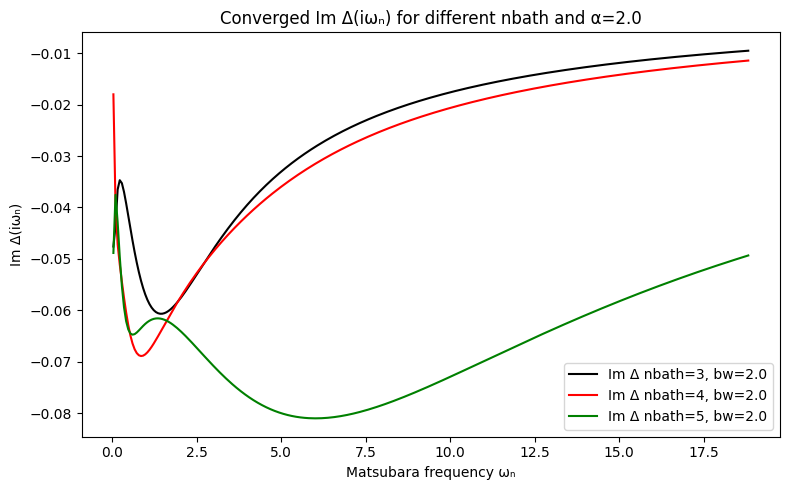

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fmin_cg
from edpyt.fit_cg import DDelta

def fit_hybrid(p, nmats, vals_true, beta, weights=None):
    """Modified hybridization fit function with optional Matsubara frequency weighting."""
    z = 1.0j * (2 * np.arange(nmats) + 1) * np.pi / beta
    delta = Delta(z)
    ddelta = DDelta(z, p.size)

    if weights is None:
        weights = np.ones(nmats)

    def chi2(p_):
        delta_fit = delta(p_)
        return np.sum(weights * np.abs(delta_fit - vals_true) ** 2)

    def dchi2(p_):
        delta_fit = delta(p_)
        ddelta_fit = ddelta(p_)
        diff = delta_fit - vals_true
        grad = 2.0 * np.real(ddelta_fit.conj().T @ (weights * diff))
        return grad

    p[:] = fmin_cg(chi2, p, fprime=dchi2, disp=False)


def test_dmft_convergence_gfloc(H, S, idx_neq, idx_inv,
                                 nbath, bandwidth, beta=100, nmats=300,
                                 max_iter=10, alpha=0.0):
    wn_real = (2 * np.arange(nmats) + 1) * np.pi / beta
    z = 1.0j * wn_real

    # Weight function: wn^(-alpha)
    weights = wn_real ** (-alpha) if alpha > 0.0 else np.ones(nmats)

    gfimp_list = []
    for i in range(len(idx_neq)):
        nsites = nbath + 1
        gf = Gfimp(nsites, nmats=nmats, beta=beta, U=3.0)
        gf.Delta.x[:] = get_initial_bath(nbath=nbath, bandwidth=bandwidth)
        gfimp_list.append(gf)

    gfimp = GfimpMulti(gfimp_list)

    def Hybrid(z):
        z = np.atleast_1d(z)
        deltas = np.stack([gf.Delta(z) for gf in gfimp])
        return np.mean(deltas, axis=0)

    gfloc = Gfloc(H, S, Hybrid, idx_neq, idx_inv, nmats=nmats, beta=beta)
    gfloc.update(mu=1.0)
    gfloc.set_local(lambda z: 0 * z)

    delta_old = np.stack([gf.free(z) for gf in gfimp])
    errors = []

    bath_history = {i: {'ek': [], 'vk': []} for i in range(len(gfimp))}

    for it in range(max_iter):
        for i, gf in enumerate(gfimp):
            fit_hybrid(gf.Delta.x, nmats, delta_old[i], beta, weights=weights)
            p = gf.Delta.x.copy()
            bath_history[i]['ek'].append(p[:nbath].copy())
            bath_history[i]['vk'].append(p[nbath:].copy())

        gfimp.update(gfloc.mu - gfloc.ed)
        gfimp.solve()

        sigma = gfimp.Sigma(z)
        gfloc.set_local(lambda z: sigma)

        delta_new = np.stack([gfloc.Delta(z)[i] for i in range(len(gfimp))])
        eps = np.linalg.norm(delta_new - delta_old)
        errors.append(eps)
        delta_old = delta_new.copy()

    return errors, bath_history, z


# ========== Main Plotting Routine ==========

if __name__ == "__main__":
    beta = 100
    nmats = 300
    max_iter = 20
    alpha = 2.0  # Weighting factor: ωₙ^(-alpha)

    H = np.eye(3) * -1.0
    S = np.eye(3)
    idx_neq = np.array([0, 1, 2])
    idx_inv = np.array([0, 1, 2])

    configs = [
        (3, 2.0),
        (4, 2.0),
        (5, 2.0),
    ]

    colors = {3: "black", 4: "red", 5: "green"}

    plt.figure(figsize=(8, 5))

    for nbath, bw in configs:
        _, bath_history, z = test_dmft_convergence_gfloc(
            H, S, idx_neq, idx_inv,
            nbath, bw,
            beta=beta,
            nmats=nmats,
            max_iter=max_iter,
            alpha=alpha
        )
        # Get final ek, vk for impurity 0
        ek = np.array(bath_history[0]['ek'][-1])
        vk = np.array(bath_history[0]['vk'][-1])
        p_final = np.concatenate([ek, vk])

        delta_fn = Delta(z)
        delta = delta_fn(p_final)

        wn = z.imag
        plt.plot(wn, delta.imag, label=f"Im Δ nbath={nbath}, bw={bw}", color=colors.get(nbath, 'gray'))

    plt.xlabel("Matsubara frequency ωₙ")
    plt.ylabel("Im Δ(iωₙ)")
    plt.title(f"Converged Im Δ(iωₙ) for different nbath and α={alpha}")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fmin_cg
from edpyt.fit_cg import DDelta

def fit_hybrid(p, nmats, vals_true, beta, weights=None):
    """Modified hybridization fit function with optional Matsubara frequency weighting."""
    z = 1.0j * (2 * np.arange(nmats) + 1) * np.pi / beta
    delta = Delta(z)
    ddelta = DDelta(z, p.size)

    if weights is None:
        weights = np.ones(nmats)

    def chi2(p_):
        delta_fit = delta(p_)
        return np.sum(weights * np.abs(delta_fit - vals_true) ** 2)

    def dchi2(p_):
        delta_fit = delta(p_)
        ddelta_fit = ddelta(p_)
        diff = delta_fit - vals_true
        grad = 2.0 * np.real(ddelta_fit.conj().T @ (weights * diff))
        return grad

    p[:] = fmin_cg(chi2, p, fprime=dchi2, disp=False)


def test_dmft_convergence_gfloc(H, S, idx_neq, idx_inv,
                                 nbath, bandwidth, beta=100, nmats=300,
                                 max_iter=10, alpha=0.0):
    wn_real = (2 * np.arange(nmats) + 1) * np.pi / beta
    z = 1.0j * wn_real

    # Weight function: wn^(-alpha)
    weights = wn_real ** (-alpha) if alpha > 0.0 else np.ones(nmats)

    gfimp_list = []
    for i in range(len(idx_neq)):
        nsites = nbath + 1
        gf = Gfimp(nsites, nmats=nmats, beta=beta, U=3.0)
        gf.Delta.x[:] = get_initial_bath(nbath=nbath, bandwidth=bandwidth)
        gfimp_list.append(gf)

    gfimp = GfimpMulti(gfimp_list)

    def Hybrid(z):
        z = np.atleast_1d(z)
        deltas = np.stack([gf.Delta(z) for gf in gfimp])
        return np.mean(deltas, axis=0)

    gfloc = Gfloc(H, S, Hybrid, idx_neq, idx_inv, nmats=nmats, beta=beta)
    gfloc.update(mu=1.0)
    gfloc.set_local(lambda z: 0 * z)

    delta_old = np.stack([gf.free(z) for gf in gfimp])
    errors = []

    bath_history = {i: {'ek': [], 'vk': []} for i in range(len(gfimp))}

    for it in range(max_iter):
        for i, gf in enumerate(gfimp):
            fit_hybrid(gf.Delta.x, nmats, delta_old[i], beta, weights=weights)
            p = gf.Delta.x.copy()
            bath_history[i]['ek'].append(p[:nbath].copy())
            bath_history[i]['vk'].append(p[nbath:].copy())

        gfimp.update(gfloc.mu - gfloc.ed)
        gfimp.solve()

        sigma = gfimp.Sigma(z)
        gfloc.set_local(lambda z: sigma)

        delta_new = np.stack([gfloc.Delta(z)[i] for i in range(len(gfimp))])
        eps = np.linalg.norm(delta_new - delta_old)
        errors.append(eps)
        delta_old = delta_new.copy()

    return errors, bath_history, z


# ========== Main Plotting Routine ==========

if __name__ == "__main__":
    beta = 100
    nmats = 300
    max_iter = 20
    alpha = 1.0  # Weighting factor: ωₙ^(-alpha)

    H = np.eye(3) * -1.0
    S = np.eye(3)
    idx_neq = np.array([0, 1, 2])
    idx_inv = np.array([0, 1, 2])

    configs = [
        (3, 2.0),
        (4, 2.0),
        (5, 2.0),
    ]

    colors = {3: "black", 4: "red", 5: "green"}

    plt.figure(figsize=(8, 5))

    for nbath, bw in configs:
        _, bath_history, z = test_dmft_convergence_gfloc(
            H, S, idx_neq, idx_inv,
            nbath, bw,
            beta=beta,
            nmats=nmats,
            max_iter=max_iter,
            alpha=alpha
        )
        # Get final ek, vk for impurity 0
        ek = np.array(bath_history[0]['ek'][-1])
        vk = np.array(bath_history[0]['vk'][-1])
        p_final = np.concatenate([ek, vk])

        delta_fn = Delta(z)
        delta = delta_fn(p_final)

        wn = z.imag
        plt.plot(wn, delta.imag, label=f"Im Δ nbath={nbath}, bw={bw}", color=colors.get(nbath, 'gray'))

    plt.xlabel("Matsubara frequency ωₙ")
    plt.ylabel("Im Δ(iωₙ)")
    plt.title(f"Converged Im Δ(iωₙ) for different nbath and α={alpha}")
    plt.legend()
    plt.tight_layout()
    plt.show()


/home/anooja/Work/software/edpyt/edpyt/lanczos.py:44: RuntimeWarning: divide by zero encountered in double_scalars
  scal(1/b,v)
/home/anooja/Work/software/edpyt/edpyt/lanczos.py:44: RuntimeWarning: divide by zero encountered in double_scalars
  scal(1/b,v)


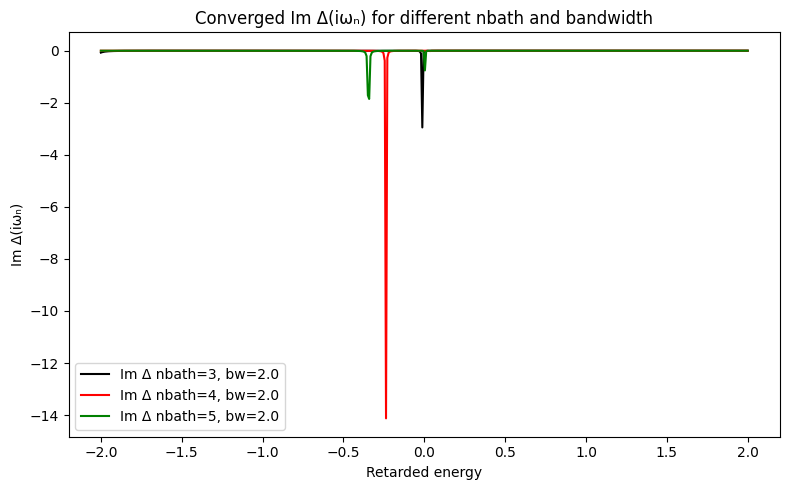

In [12]:
def test_dmft_convergence_gfloc(H, S, idx_neq, idx_inv,
                                 nbath, bandwidth, beta=100, nmats=300, max_iter=10):
    wn = 1j * (2 * np.arange(nmats) + 1) * np.pi / beta
    z = wn
    delta_fn = Delta(z)

    gfimp_list = []
    for i in range(len(idx_neq)):
        nsites = nbath + 1
        gf = Gfimp(nsites, nmats=nmats, beta=beta, U=3.0)
        gf.Delta.x[:] = get_initial_bath(nbath=nbath, bandwidth=bandwidth)
        gfimp_list.append(gf)

    gfimp = GfimpMulti(gfimp_list)

    def Hybrid(z):
        z = np.atleast_1d(z)
        deltas = np.stack([gf.Delta(z) for gf in gfimp])
        return np.mean(deltas, axis=0)

    gfloc = Gfloc(H, S, Hybrid, idx_neq, idx_inv, nmats=nmats, beta=beta)
    gfloc.update(mu=1.0)
    gfloc.set_local(lambda z: 0 * z)

    delta_old = np.stack([gf.free(z) for gf in gfimp])
    errors = []


    bath_history = {i: {'ek': [], 'vk': []} for i in range(len(gfimp))}

    for it in range(max_iter):
        for i, gf in enumerate(gfimp):
            fit_hybrid(gf.Delta.x, nmats, delta_old[i], beta)
            p = gf.Delta.x.copy()
            bath_history[i]['ek'].append(p[:nbath].copy())
            bath_history[i]['vk'].append(p[nbath:].copy())

        gfimp.update(gfloc.mu - gfloc.ed)
        gfimp.solve()

        sigma = gfimp.Sigma(z)
        gfloc.set_local(lambda z: sigma)

        delta_new = np.stack([gfloc.Delta(z)[i] for i in range(len(gfimp))])
        eps = np.linalg.norm(delta_new - delta_old)
        errors.append(eps)
        delta_old = delta_new.copy()

    return errors, bath_history, z


if __name__ == "__main__":
    beta = 100
    nmats = 300
    max_iter = 20
    z_ret = np.linspace(-2, 2, 500) + 1j * 1e-3
    H = np.eye(3) * -1.0
    S = np.eye(3)
    idx_neq = np.array([0, 1, 2])
    idx_inv = np.array([0, 1, 2])

    configs = [
        (3, 2.0),
        (4, 2.0),
        (5, 2.0),
    ]

    colors = {3: "black", 4: "red", 5: "green"}

    plt.figure(figsize=(8, 5))

    for nbath, bw in configs:
        _, bath_history, z = test_dmft_convergence_gfloc(
            H, S, idx_neq, idx_inv,
            nbath, bw, beta=beta, nmats=nmats,
            max_iter=max_iter
        )
        # Get final ek, vk for impurity 0
        ek = np.array(bath_history[0]['ek'][-1])
        vk = np.array(bath_history[0]['vk'][-1])
        p_final = np.concatenate([ek, vk])

        delta_fn = Delta(z_ret)
        delta = delta_fn(p_final)

        wn = z_ret.real
        plt.plot(wn, delta.imag, label=f"Im Δ nbath={nbath}, bw={bw}", color=colors.get(nbath, 'gray'))

    plt.xlabel("Retarded energy")
    plt.ylabel("Im Δ(iωₙ)")
    plt.title("Converged Im Δ(iωₙ) for different nbath and bandwidth")
    plt.legend()
    plt.tight_layout()
    plt.show()

/home/anooja/Work/software/edpyt/edpyt/lanczos.py:44: RuntimeWarning: divide by zero encountered in double_scalars
  scal(1/b,v)


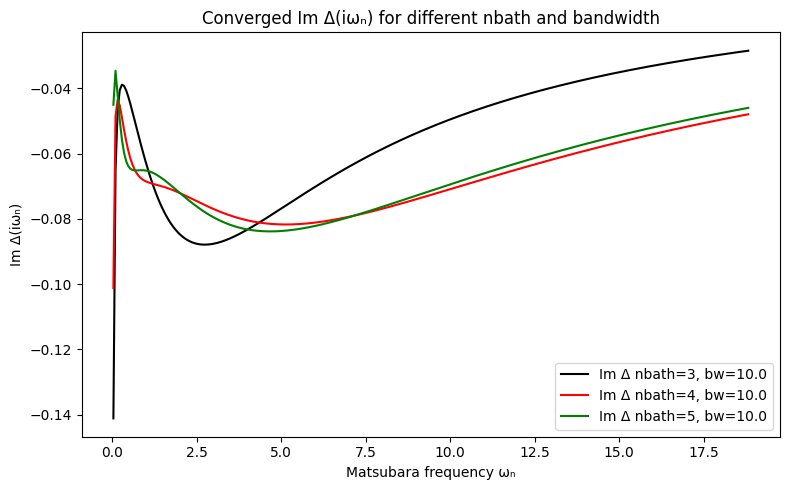

In [3]:
def test_dmft_convergence_gfloc(H, S, idx_neq, idx_inv,
                                 nbath, bandwidth, beta=100, nmats=300, max_iter=10):
    wn = 1j * (2 * np.arange(nmats) + 1) * np.pi / beta
    z = wn
    delta_fn = Delta(z)

    gfimp_list = []
    for i in range(len(idx_neq)):
        nsites = nbath + 1
        gf = Gfimp(nsites, nmats=nmats, beta=beta, U=3.0)
        gf.Delta.x[:] = get_initial_bath(nbath=nbath, bandwidth=bandwidth)
        gfimp_list.append(gf)

    gfimp = GfimpMulti(gfimp_list)

    def Hybrid(z):
        z = np.atleast_1d(z)
        deltas = np.stack([gf.Delta(z) for gf in gfimp])
        return np.mean(deltas, axis=0)

    gfloc = Gfloc(H, S, Hybrid, idx_neq, idx_inv, nmats=nmats, beta=beta)
    gfloc.update(mu=1.0)
    gfloc.set_local(lambda z: 0 * z)

    delta_old = np.stack([gf.free(z) for gf in gfimp])
    errors = []


    bath_history = {i: {'ek': [], 'vk': []} for i in range(len(gfimp))}

    for it in range(max_iter):
        for i, gf in enumerate(gfimp):
            fit_hybrid(gf.Delta.x, nmats, delta_old[i], beta)
            p = gf.Delta.x.copy()
            bath_history[i]['ek'].append(p[:nbath].copy())
            bath_history[i]['vk'].append(p[nbath:].copy())

        gfimp.update(gfloc.mu - gfloc.ed)
        gfimp.solve()

        sigma = gfimp.Sigma(z)
        gfloc.set_local(lambda z: sigma)

        delta_new = np.stack([gfloc.Delta(z)[i] for i in range(len(gfimp))])
        eps = np.linalg.norm(delta_new - delta_old)
        errors.append(eps)
        delta_old = delta_new.copy()

    return errors, bath_history, z


if __name__ == "__main__":
    beta = 100
    nmats = 300
    max_iter = 20

    H = np.eye(3) * -1.0
    S = np.eye(3)
    idx_neq = np.array([0, 1, 2])
    idx_inv = np.array([0, 1, 2])

    configs = [
        (3, 10.0),
        (4, 10.0),
        (5, 10.0),
    ]

    colors = {3: "black", 4: "red", 5: "green"}

    plt.figure(figsize=(8, 5))

    for nbath, bw in configs:
        _, bath_history, z = test_dmft_convergence_gfloc(
            H, S, idx_neq, idx_inv,
            nbath, bw, beta=beta, nmats=nmats,
            max_iter=max_iter
        )
        # Get final ek, vk for impurity 0
        ek = np.array(bath_history[0]['ek'][-1])
        vk = np.array(bath_history[0]['vk'][-1])
        p_final = np.concatenate([ek, vk])

        delta_fn = Delta(z)
        delta = delta_fn(p_final)

        wn = z.imag
        plt.plot(wn, delta.imag, label=f"Im Δ nbath={nbath}, bw={bw}", color=colors.get(nbath, 'gray'))

    plt.xlabel("Matsubara frequency ωₙ")
    plt.ylabel("Im Δ(iωₙ)")
    plt.title("Converged Im Δ(iωₙ) for different nbath and bandwidth")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
def test_dmft_convergence_gfloc(H, S, idx_neq, idx_inv,
                                 nbath, bandwidth, beta=100, nmats=300, max_iter=10):
    wn = 1j * (2 * np.arange(nmats) + 1) * np.pi / beta
    z = wn
    delta_fn = Delta(z)

    gfimp_list = []
    for i in range(len(idx_neq)):
        nsites = nbath + 1
        gf = Gfimp(nsites, nmats=nmats, beta=beta, U=3.0)
        gf.Delta.x[:] = get_initial_bath(nbath=nbath, bandwidth=bandwidth)
        gfimp_list.append(gf)

    gfimp = GfimpMulti(gfimp_list)

    def Hybrid(z):
        z = np.atleast_1d(z)
        deltas = np.stack([gf.Delta(z) for gf in gfimp])
        return np.mean(deltas, axis=0)

    gfloc = Gfloc(H, S, Hybrid, idx_neq, idx_inv, nmats=nmats, beta=beta)
    gfloc.update(mu=1.0)
    gfloc.set_local(lambda z: 0 * z)

    delta_old = np.stack([gf.free(z) for gf in gfimp])
    errors = []


    bath_history = {i: {'ek': [], 'vk': []} for i in range(len(gfimp))}

    for it in range(max_iter):
        for i, gf in enumerate(gfimp):
            fit_hybrid(gf.Delta.x, nmats, delta_old[i], beta)
            p = gf.Delta.x.copy()
            bath_history[i]['ek'].append(p[:nbath].copy())
            bath_history[i]['vk'].append(p[nbath:].copy())

        gfimp.update(gfloc.mu - gfloc.ed)
        gfimp.solve()

        sigma = gfimp.Sigma(z)
        gfloc.set_local(lambda z: sigma)

        delta_new = np.stack([gfloc.Delta(z)[i] for i in range(len(gfimp))])
        eps = np.linalg.norm(delta_new - delta_old)
        errors.append(eps)
        delta_old = delta_new.copy()

    return errors, bath_history, z


if __name__ == "__main__":
    beta = 100
    nmats = 300
    max_iter = 20

    H = np.eye(3) * -1.0
    S = np.eye(3)
    idx_neq = np.array([0, 1, 2])
    idx_inv = np.array([0, 1, 2])

    configs = [
        (3, 4.0),
        (4, 4.0),
        (5, 4.0),
        (6, 4.0),
    ]

    colors = {3: "black", 4: "red", 5: "green"}

    plt.figure(figsize=(8, 5))

    for nbath, bw in configs:
        _, bath_history, z = test_dmft_convergence_gfloc(
            H, S, idx_neq, idx_inv,
            nbath, bw, beta=beta, nmats=nmats,
            max_iter=max_iter
        )
        # Get final ek, vk for impurity 0
        ek = np.array(bath_history[0]['ek'][-1])
        vk = np.array(bath_history[0]['vk'][-1])
        p_final = np.concatenate([ek, vk])

        delta_fn = Delta(z)
        delta = delta_fn(p_final)

        wn = z.imag
        plt.plot(wn, delta.imag, label=f"Im Δ nbath={nbath}, bw={bw}", color=colors.get(nbath, 'gray'))

    plt.xlabel("Matsubara frequency ωₙ")
    plt.ylabel("Im Δ(iωₙ)")
    plt.title("Converged Im Δ(iωₙ) for different nbath and bandwidth")
    plt.legend()
    plt.tight_layout()
    plt.show()

/home/anooja/Work/software/edpyt/edpyt/lanczos.py:44: RuntimeWarning: divide by zero encountered in double_scalars
  scal(1/b,v)


/home/anooja/Work/software/edpyt/edpyt/lanczos.py:44: RuntimeWarning: divide by zero encountered in double_scalars
  scal(1/b,v)
/home/anooja/Work/software/edpyt/edpyt/lanczos.py:44: RuntimeWarning: divide by zero encountered in double_scalars
  scal(1/b,v)


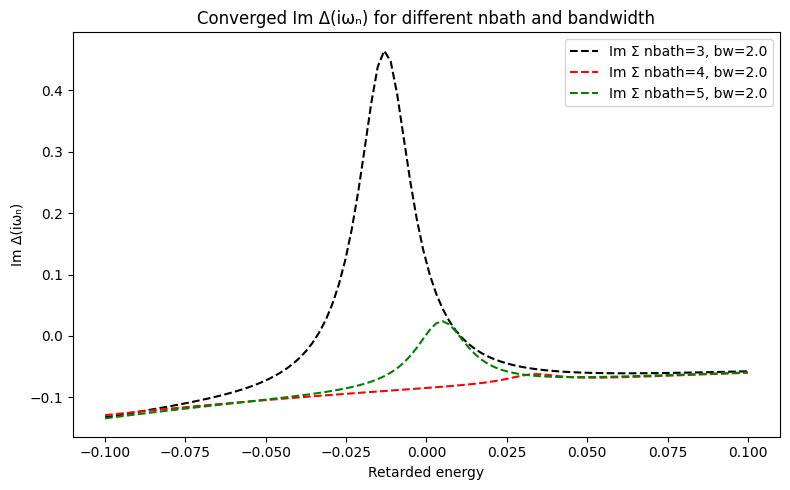

In [7]:
def test_dmft_convergence_gfloc(H, S, idx_neq, idx_inv,
                                 nbath, bandwidth, beta=100, nmats=300, max_iter=10):
    wn = 1j * (2 * np.arange(nmats) + 1) * np.pi / beta
    z = wn
    delta_fn = Delta(z)

    gfimp_list = []
    for i in range(len(idx_neq)):
        nsites = nbath + 1
        gf = Gfimp(nsites, nmats=nmats, beta=beta, U=3.0)
        gf.Delta.x[:] = get_initial_bath(nbath=nbath, bandwidth=bandwidth)
        gfimp_list.append(gf)

    gfimp = GfimpMulti(gfimp_list)

    def Hybrid(z):
        z = np.atleast_1d(z)
        deltas = np.stack([gf.Delta(z) for gf in gfimp])
        return np.mean(deltas, axis=0)

    gfloc = Gfloc(H, S, Hybrid, idx_neq, idx_inv, nmats=nmats, beta=beta)
    gfloc.update(mu=1.0)
    gfloc.set_local(lambda z: 0 * z)

    delta_old = np.stack([gf.free(z) for gf in gfimp])
    errors = []


    bath_history = {i: {'ek': [], 'vk': []} for i in range(len(gfimp))}

    for it in range(max_iter):
        for i, gf in enumerate(gfimp):
            fit_hybrid(gf.Delta.x, nmats, delta_old[i], beta)
            p = gf.Delta.x.copy()
            bath_history[i]['ek'].append(p[:nbath].copy())
            bath_history[i]['vk'].append(p[nbath:].copy())

        gfimp.update(gfloc.mu - gfloc.ed)
        gfimp.solve()

        sigma = gfimp.Sigma(z)
        gfloc.set_local(lambda z: sigma)

        delta_new = np.stack([gfloc.Delta(z)[i] for i in range(len(gfimp))])
        eps = np.linalg.norm(delta_new - delta_old)
        errors.append(eps)
        delta_old = delta_new.copy()

    return errors, bath_history, z, gfimp


if __name__ == "__main__":
    beta = 100
    nmats = 300
    max_iter = 20
    z_ret = np.linspace(-0.1,0.1, 100) + 1j*0.01
    H = np.eye(3) * -1.0
    S = np.eye(3)
    idx_neq = np.array([0, 1, 2])
    idx_inv = np.array([0, 1, 2])

    configs = [
        (3, 2.0),
        (4, 2.0),
        (5, 2.0),
    ]

    colors = {3: "black", 4: "red", 5: "green"}

    plt.figure(figsize=(8, 5))

    for nbath, bw in configs:
        _, bath_history, z, gfimp = test_dmft_convergence_gfloc(
            H, S, idx_neq, idx_inv,
            nbath, bw, beta=beta, nmats=nmats,
            max_iter=max_iter
        )

        # --- Get Sigma from final DMFT step ---
        sigma = gfimp.Sigma(z_ret)        # Already computed at convergence
        sigma0 = sigma[0]             # Impurity 0

        plt.plot(z_ret.real, sigma0.imag, '--', color=colors.get(nbath, 'gray'),
                 label=f"Im Σ nbath={nbath}, bw={bw}")


    plt.xlabel("Retarded energy")
    plt.ylabel("Im Δ(iωₙ)")
    plt.title("Converged Im Δ(iωₙ) for different nbath and bandwidth")
    plt.legend()
    plt.tight_layout()
    plt.show()

/home/anooja/Work/software/edpyt/edpyt/lanczos.py:44: RuntimeWarning: divide by zero encountered in double_scalars
  scal(1/b,v)
/home/anooja/Work/software/edpyt/edpyt/lanczos.py:44: RuntimeWarning: divide by zero encountered in double_scalars
  scal(1/b,v)


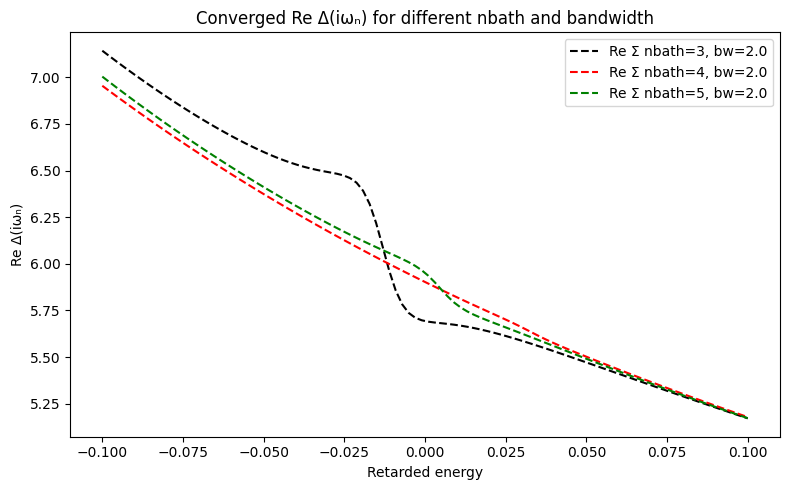

In [9]:
def test_dmft_convergence_gfloc(H, S, idx_neq, idx_inv,
                                 nbath, bandwidth, beta=100, nmats=300, max_iter=10):
    wn = 1j * (2 * np.arange(nmats) + 1) * np.pi / beta
    z = wn
    delta_fn = Delta(z)

    gfimp_list = []
    for i in range(len(idx_neq)):
        nsites = nbath + 1
        gf = Gfimp(nsites, nmats=nmats, beta=beta, U=3.0)
        gf.Delta.x[:] = get_initial_bath(nbath=nbath, bandwidth=bandwidth)
        gfimp_list.append(gf)

    gfimp = GfimpMulti(gfimp_list)

    def Hybrid(z):
        z = np.atleast_1d(z)
        deltas = np.stack([gf.Delta(z) for gf in gfimp])
        return np.mean(deltas, axis=0)

    gfloc = Gfloc(H, S, Hybrid, idx_neq, idx_inv, nmats=nmats, beta=beta)
    gfloc.update(mu=1.0)
    gfloc.set_local(lambda z: 0 * z)

    delta_old = np.stack([gf.free(z) for gf in gfimp])
    errors = []


    bath_history = {i: {'ek': [], 'vk': []} for i in range(len(gfimp))}

    for it in range(max_iter):
        for i, gf in enumerate(gfimp):
            fit_hybrid(gf.Delta.x, nmats, delta_old[i], beta)
            p = gf.Delta.x.copy()
            bath_history[i]['ek'].append(p[:nbath].copy())
            bath_history[i]['vk'].append(p[nbath:].copy())

        gfimp.update(gfloc.mu - gfloc.ed)
        gfimp.solve()

        sigma = gfimp.Sigma(z)
        gfloc.set_local(lambda z: sigma)

        delta_new = np.stack([gfloc.Delta(z)[i] for i in range(len(gfimp))])
        eps = np.linalg.norm(delta_new - delta_old)
        errors.append(eps)
        delta_old = delta_new.copy()

    return errors, bath_history, z, gfimp


if __name__ == "__main__":
    beta = 100
    nmats = 300
    max_iter = 20
    z_ret = np.linspace(-0.1,0.1, 100) + 1j*0.01
    H = np.eye(3) * -1.0
    S = np.eye(3)
    idx_neq = np.array([0, 1, 2])
    idx_inv = np.array([0, 1, 2])

    configs = [
        (3, 2.0),
        (4, 2.0),
        (5, 2.0),
    ]

    colors = {3: "black", 4: "red", 5: "green"}

    plt.figure(figsize=(8, 5))

    for nbath, bw in configs:
        _, bath_history, z, gfimp = test_dmft_convergence_gfloc(
            H, S, idx_neq, idx_inv,
            nbath, bw, beta=beta, nmats=nmats,
            max_iter=max_iter
        )

        # --- Get Sigma from final DMFT step ---
        sigma = gfimp.Sigma(z_ret)        # Already computed at convergence
        sigma0 = sigma[0]             # Impurity 0

        plt.plot(z_ret.real, sigma0.real, '--', color=colors.get(nbath, 'gray'),
                 label=f"Re Σ nbath={nbath}, bw={bw}")


    plt.xlabel("Retarded energy")
    plt.ylabel("Re Δ(iωₙ)")
    plt.title("Converged Re Δ(iωₙ) for different nbath and bandwidth")
    plt.legend()
    plt.tight_layout()
    plt.show()

/home/anooja/Work/software/edpyt/edpyt/lanczos.py:44: RuntimeWarning: divide by zero encountered in double_scalars
  scal(1/b,v)


(300,)


/home/anooja/Work/software/edpyt/edpyt/lanczos.py:44: RuntimeWarning: divide by zero encountered in double_scalars
  scal(1/b,v)


(300,)


KeyboardInterrupt: 

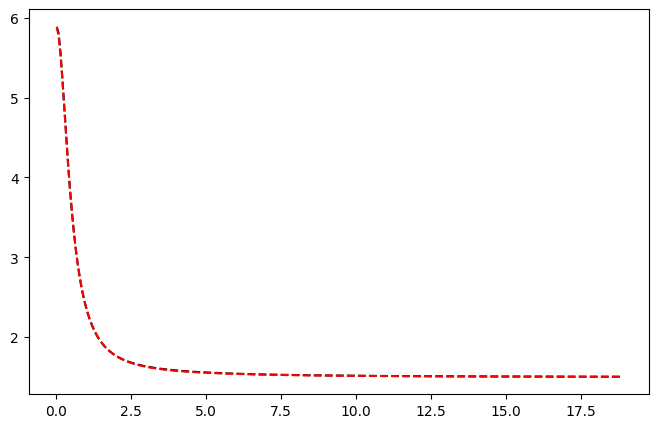

In [4]:
def test_dmft_convergence_gfloc(H, S, idx_neq, idx_inv,
                                 nbath, bandwidth, beta=100, nmats=300, max_iter=10):
    wn = 1j * (2 * np.arange(nmats) + 1) * np.pi / beta
    z = wn
    delta_fn = Delta(z)

    gfimp_list = []
    for i in range(len(idx_neq)):
        nsites = nbath + 1
        gf = Gfimp(nsites, nmats=nmats, beta=beta, U=3.0)
        gf.Delta.x[:] = get_initial_bath(nbath=nbath, bandwidth=bandwidth)
        gfimp_list.append(gf)

    gfimp = GfimpMulti(gfimp_list)

    def Hybrid(z):
        z = np.atleast_1d(z)
        deltas = np.stack([gf.Delta(z) for gf in gfimp])
        return np.mean(deltas, axis=0)

    gfloc = Gfloc(H, S, Hybrid, idx_neq, idx_inv, nmats=nmats, beta=beta)
    gfloc.update(mu=1.0)
    gfloc.set_local(lambda z: 0 * z)

    delta_old = np.stack([gf.free(z) for gf in gfimp])
    errors = []


    bath_history = {i: {'ek': [], 'vk': []} for i in range(len(gfimp))}

    for it in range(max_iter):
        for i, gf in enumerate(gfimp):
            fit_hybrid(gf.Delta.x, nmats, delta_old[i], beta)
            p = gf.Delta.x.copy()
            bath_history[i]['ek'].append(p[:nbath].copy())
            bath_history[i]['vk'].append(p[nbath:].copy())

        gfimp.update(gfloc.mu - gfloc.ed)
        gfimp.solve()

        sigma = gfimp.Sigma(z)
        gfloc.set_local(lambda z: sigma)

        delta_new = np.stack([gfloc.Delta(z)[i] for i in range(len(gfimp))])
        eps = np.linalg.norm(delta_new - delta_old)
        errors.append(eps)
        delta_old = delta_new.copy()

    return errors, bath_history, z, gfimp


if __name__ == "__main__":
    beta = 100
    nmats = 300
    max_iter = 20

    H = np.eye(3) * -1.0
    S = np.eye(3)
    idx_neq = np.array([0, 1, 2])
    idx_inv = np.array([0, 1, 2])

    configs = [
        (3, 2.0),
        (4, 2.0),
        (5, 2.0),
    ]

    colors = {3: "black", 4: "red", 5: "green"}

    plt.figure(figsize=(8, 5))

    for nbath, bw in configs:
        _, bath_history, z, gfimp = test_dmft_convergence_gfloc(
            H, S, idx_neq, idx_inv,
            nbath, bw, beta=beta, nmats=nmats,
            max_iter=max_iter
        )

        # --- Get Sigma from final DMFT step ---
        sigma = gfimp.Sigma(z)        # Already computed at convergence
        sigma0 = sigma[0]             # Impurity 0
        print(sigma0.shape)
        plt.plot(wn, sigma0.real, '--', color=colors.get(nbath, 'gray'),
                 label=f"Re Σ nbath={nbath}, bw={bw}")


    plt.xlabel("Matsubara frequency ωₙ")
    plt.ylabel("Re Σ")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [19]:
def random_initial_bath(nbath, bandwidth=2.0, noise_scale=0.1, seed=None):
    np.random.seed(seed)
    if nbath % 2 == 1:
        base = np.linspace(-bandwidth, bandwidth, nbath)
    else:
        # Slight asymmetry near center
        nh = nbath // 2
        base = np.concatenate([
            np.linspace(-bandwidth, -0.2, nh),
            np.linspace(+0.2, +bandwidth, nh)
        ])
    noise = noise_scale * (2 * np.random.rand(nbath) - 1)
    return base + noise


In [22]:
for i in range(3):
   print(random_initial_bath(5,noise_scale=0.2))

[-2.08656499 -0.8042627  -0.0623784   1.10107231  2.05930864]
[-2.1347321  -1.16454758  0.02960728  0.91845803  2.07187936]
[-1.81279598 -0.91137098  0.05751724  0.82389936  1.95463534]
